# Pixelated source and smooth lens modeling
### Fit the source light as a regularised grid of pixels along as parameters of the smooth lens model (SIE + shear)

The true source is an elliptical Sérsic profile here, but can be anything.

__NOTE__: In practice, we would _never_ optimize straight ahead both a pixelated source and smooth lens (cf. large errors and residuals at the end of this notebooks). We would rather do:
1. first optimize smooth source and lens parameters;
2. fix the smooth lens model and fit for a pixelated source;
3. final optimization of both pixelated source and smooth lens.

__last updated__: 14/08/21

In [1]:
# Basic imports
from time import time
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline
plt.rc('image', interpolation='none')

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# jaxtronomy imports
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Analysis.plot import Plotter

# Universal font size
FS = 18

np.random.seed(18)

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
                        'center_x': 0.4, 'center_y': 0.15}]

### Lens model (SIE + external shear)

In [4]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

### PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [6]:
exp_time = None
sigma_bkd = 0.05
noise_map = sigma_bkd * np.ones((npix, npix))
kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)

### Image model

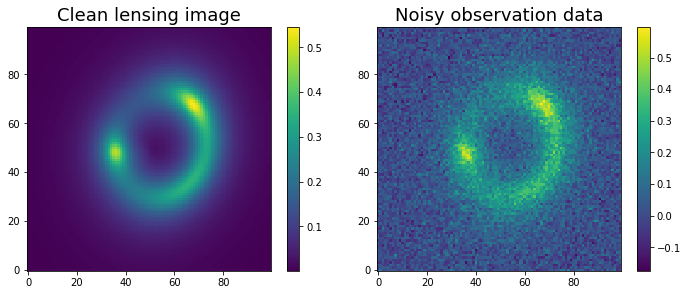

In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}
lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image = lens_image.model(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)

true_source = lens_image.source_surface_brightness(kwargs_source=kwargs_source_light, 
                                                   de_lensed=True, unconvolved=True)

# Observed noisy data
data = lens_image.simulation(kwargs_lens=kwargs_lens_mass,
                              kwargs_source=kwargs_source_light,
                              kwargs_lens_light=kwargs_lens_light)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Source fitting on a pixelated grid with starlet regularisation

### Create a model for fitting

In [8]:
# Recreate a Noise object with true noise map
kwargs_noise_fit = {'background_rms': sigma_bkd, 'noise_map': noise_map}
fit_noise = Noise(npix, npix, **kwargs_noise_fit)

# Change only the source light model
fit_source_light_model_list = ['PIXELATED']
kwargs_pixelated_source = {
    'pixel_scale_factor': 0.5, # scaling factor for source pixel size
}
fit_source_light_model = LightModel(fit_source_light_model_list,
                                    kwargs_pixelated=kwargs_pixelated_source)
fit_lens_image = LensImage(pixel_grid, psf, noise_class=fit_noise,
                             lens_model_class=lens_mass_model,
                             source_model_class=fit_source_light_model,
                             lens_light_model_class=lens_light_model,
                             kwargs_numerics=kwargs_numerics)

# 1D coordinate arrays for source grid interpolation
x_coords = fit_lens_image.Grid.pixel_coordinates[0][0, :]
y_coords = fit_lens_image.Grid.pixel_coordinates[1][:, 0]

In [9]:
kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': fit_source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.5, 'e1': 0.1, 'e2': -0.05, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma1': -0.02, 'gamma2': 0.02}],
    'kwargs_source': [{'pixels': 1e-8}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{}],
}
kwargs_fixed = {
    # we still fix the lens center, because in practice it is constrained by the lens light
    'kwargs_lens': [{'center_x': 0., 'center_y': 0.}, {'ra_0': 0., 'dec_0': 0.}],
    # uncomment the following line to fix all lens parameters
    #'kwargs_lens': kwargs_lens_mass,
    'kwargs_source': [{}],
}
parameters = Parameters(fit_lens_image, kwargs_init, kwargs_prior, kwargs_fixed)
print("num. parameters:", parameters.num_parameters)

num. parameters: 40005


### Loss function & optimizer

In [10]:
loss = Loss(data, fit_lens_image, parameters, 
            likelihood_type='l2_norm',
            regularization_terms=['l1_starlet_source', 
                                  'l1_battle_source',
                                  'positivity_source'], 
            regularization_strengths=[(5, 3), 3, 3],
            prior_terms=None)
optimizer = Optimizer(loss, parameters)
print(f"Initial loss: {optimizer.loss(parameters.initial_values()):.2f}")
print("Data points used in likelihood:", loss.likelihood_num_data_points)

Initial loss: 6.11
Data points used in likelihood: 10000


### Optimize using `optax`

In [11]:
best_fit, logL_best_fit, extra_fields, runtime \
    = optimizer.optax(max_iterations=500, 
                      init_learning_rate=1e-2,
                      restart_from_init=True)
print(f"Runtime: {runtime} s")
print(f"Final loss: {logL_best_fit:.2f}")
kwargs_final = parameters.best_fit_values(as_kwargs=True)

Runtime: 34.24652314186096 s
Final loss: 2.12


### Display results

/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax-strong-lensing/jaxtronomy/Analysis/plot.py:114: UserWarning: True source array has been interpolated to match model array
  warnings.warn("True source array has been interpolated to match model array")


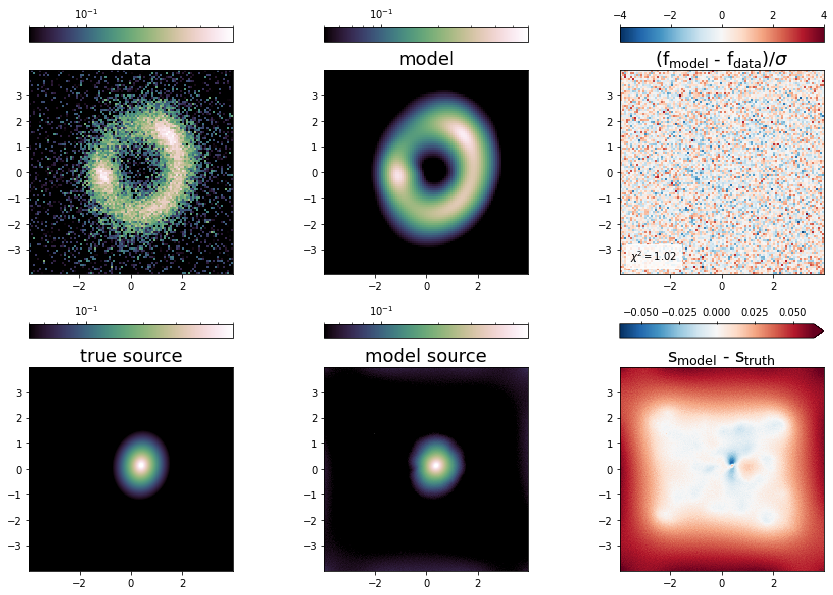

In [12]:
plotter = Plotter(base_fontsize=FS, flux_vmin=5e-2, flux_vmax=6e-1)
plotter.set_data(data)
plotter.set_true_source(true_source)
plotter.model_summary(fit_lens_image, kwargs_final,
                      likelihood_mask=loss.likelihood_mask)

In [13]:
def print_errors(kwargs):
    def _print_error(name, value, estimate):
        spaces = " " * (10 - len(name))
        if value != 0:
            error = 100 * abs(value - estimate) / value
            print(name + ":" + spaces + f"{error:.2f} % ({value} => {estimate})")
        else:
            error = abs(value - estimate)
            print(name + ":" + spaces + f"{error:.2f} [abs] ({value} => {estimate})")
    print("Error")
    print("-----")
    for i, params in enumerate(kwargs_lens_mass):
        for key, value in params.items():
            fit = kwargs['kwargs_lens'][i][key]
            _print_error(key, value, fit)
        
print_errors(kwargs_final)

Error
-----
theta_E:   0.01 % (1.6 => 1.5997702190744747)
e1:        42.00 % (0.15 => 0.08699323051720824)
e2:        -63.65 % (-0.04 => -0.014541845640139106)
center_x:  0.00 [abs] (0.0 => 0.0)
center_y:  0.00 [abs] (0.0 => 0.0)
gamma1:    -340.70 % (-0.01 => -0.04406975693977232)
gamma2:    22.68 % (0.03 => 0.03680389009204388)
ra_0:      0.00 [abs] (0.0 => 0.0)
dec_0:     0.00 [abs] (0.0 => 0.0)
